In [5]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import sklearn.svm as svm
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import itertools
import xgboost as xgb
import shap

In [2]:
### 导入数据
df = pd.read_csv('./OnlineNewsPopularity/OnlineNewsPopularity.csv')
keys = np.array(df.columns)
dic = {}
for colname in df:
    arr = df.loc[:,colname].values
    dic[colname] = arr
dic[keys[-1]] = dic[keys[-1]] > 1400    # 将shares从数量值转化为布尔值

# 构建数据集与标签集
data_set = dic[keys[1]].reshape(-1,1)   # 数据集
for i in range(2,len(keys)-1):
    data_set = np.append(data_set, dic[keys[i]].reshape(-1,1), axis = 1)
label_set = dic[keys[-1]]               # 标签集

In [3]:
data_set = data_set[np.lexsort(-data_set.T[0, None])]
# print(np.mean(data_set[:,0]), np.median(data_set[:,0])):354.53, 339
A_idx = np.argwhere(data_set[:,0] > np.median(data_set[:,0]))
B_idx = np.argwhere(data_set[:,0] <= np.median(data_set[:,0]))
# print(len(A_idx), len(B_idx)): 19775, 19869

In [14]:
### 取A_idx为训练集，B_idx为测试集（7：3）
x_train = data_set[A_idx]
y_train = label_set[A_idx]
x_, x_test, y_, y_test = train_test_split(data_set[B_idx], label_set[B_idx], test_size=0.3)

### 数据预处理
## 分别对训练集、验证集和测试集进行数据标准化
scaler = StandardScaler()     
x_train = scaler.fit_transform(x_train.squeeze())     # 完整训练集
x_test = scaler.fit_transform(x_test.squeeze())       # 测试集

In [4]:
# 绘制混淆矩阵（直接调用）
def plot_confusion_matrix(cm, labels_name, title):
    '''
    inputs:
    cm: confusion_matrix result
    labels_name: list, the label names draw on the plt
    title: plt name

    outputs:
    show the visualization confusion matrix
    '''
    plt.figure(figsize=(15,8),dpi=100)
    plt.subplot(1,2,1)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{}'.format(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if int(num) > thresh else "black")
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

    
    plt.subplot(1,2,2)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # 归一化
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.Blues)    # 在特定的窗口上显示图像
    plt.title(title)    # 图像标题
    plt.colorbar()
    num_local = np.array(range(len(labels_name)))    
    plt.xticks(num_local, labels_name, rotation=90)    # 将标签印在x轴坐标上
    plt.yticks(num_local, labels_name)    # 将标签印在y轴坐标上
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        num = '{:.2f}'.format(cm[i, j])
        plt.text(j, i, num,
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white" if float(num) > thresh else "black")
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
# 混淆矩阵绘制代码来源以下两篇博客：
# https://blog.csdn.net/kane7csdn/article/details/83756583
# https://blog.csdn.net/qq_18617009/article/details/103345308

d:\anaconda3\envs\jupyter\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\anaconda3\envs\jupyter\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\anaconda3\envs\jupyter\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[10:54:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


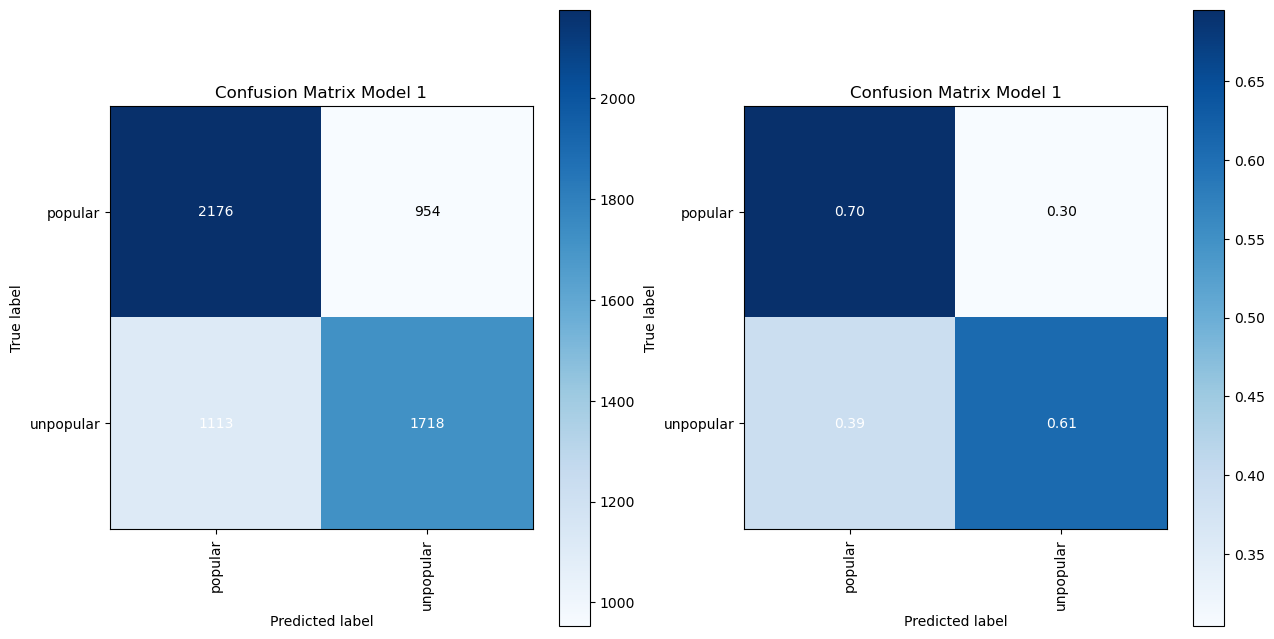

acc: 0.6532460996477101
pre: 0.6429640718562875
recall: 0.606852702225362
f1: 0.6243866981646375
AUCf1: 0.6510301849784957


In [16]:
### 模型训练
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=160, objective='binary:logistic')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

## 绘制预测结果
# {'svm__C': 1, 'svm__gamma': 0.01}
cm = confusion_matrix(y_test, y_pred)
labels_name = ['popular','unpopular']
plot_confusion_matrix(cm, labels_name, "Confusion Matrix Model 1")
plt.show()
print("acc: " + str(accuracy_score(y_test, y_pred)))
print("pre: " + str(precision_score(y_test, y_pred)))
print("recall: " + str(recall_score(y_test, y_pred)))
print("f1: " + str(f1_score(y_test, y_pred)))
print("AUCf1: " + str(roc_auc_score(y_test, y_pred)))

In [17]:
### 取B_idx为训练集，A_idx为测试集（7：3）
x_train = data_set[B_idx]
y_train = label_set[B_idx]
x_, x_test, y_, y_test = train_test_split(data_set[A_idx], label_set[A_idx], test_size=0.3)

### 数据预处理
## 分别对训练集、验证集和测试集进行数据标准化
scaler = StandardScaler()     
x_train = scaler.fit_transform(x_train.squeeze())     # 完整训练集
x_test = scaler.fit_transform(x_test.squeeze())       # 测试集

d:\anaconda3\envs\jupyter\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\anaconda3\envs\jupyter\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\anaconda3\envs\jupyter\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[10:55:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


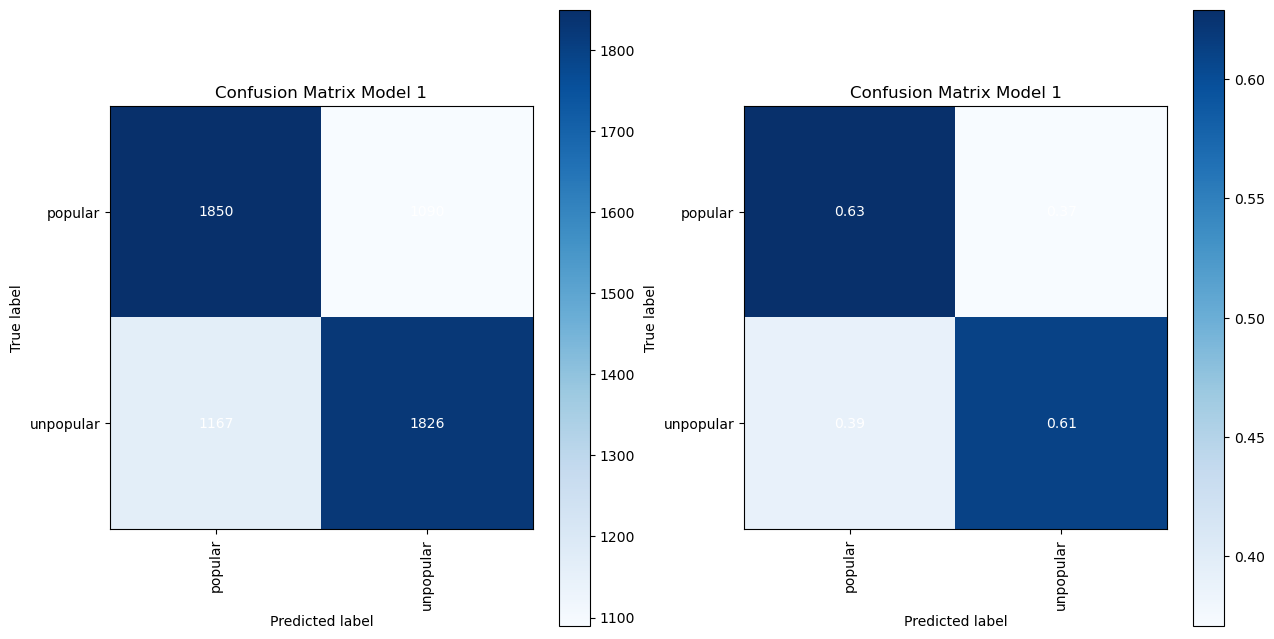

acc: 0.6195853699646048
pre: 0.6262002743484225
recall: 0.610090210491146
f1: 0.6180402775427315
AUCf1: 0.619670955585709


In [18]:
### 模型训练
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=160, objective='binary:logistic')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

## 绘制预测结果
# {'svm__C': 1, 'svm__gamma': 0.01}
cm = confusion_matrix(y_test, y_pred)
labels_name = ['popular','unpopular']
plot_confusion_matrix(cm, labels_name, "Confusion Matrix Model 1")
plt.show()
print("acc: " + str(accuracy_score(y_test, y_pred)))
print("pre: " + str(precision_score(y_test, y_pred)))
print("recall: " + str(recall_score(y_test, y_pred)))
print("f1: " + str(f1_score(y_test, y_pred)))
print("AUCf1: " + str(roc_auc_score(y_test, y_pred)))

In [6]:
### 针对A_idx进行训练
x_train, x_test, y_train, y_test = train_test_split(data_set[A_idx], label_set[A_idx], test_size=0.3)

### 数据预处理
## 分别对训练集、验证集和测试集进行数据标准化
scaler = StandardScaler()     
x_train = scaler.fit_transform(x_train.squeeze())     # 完整训练集
x_test = scaler.fit_transform(x_test.squeeze())       # 测试集

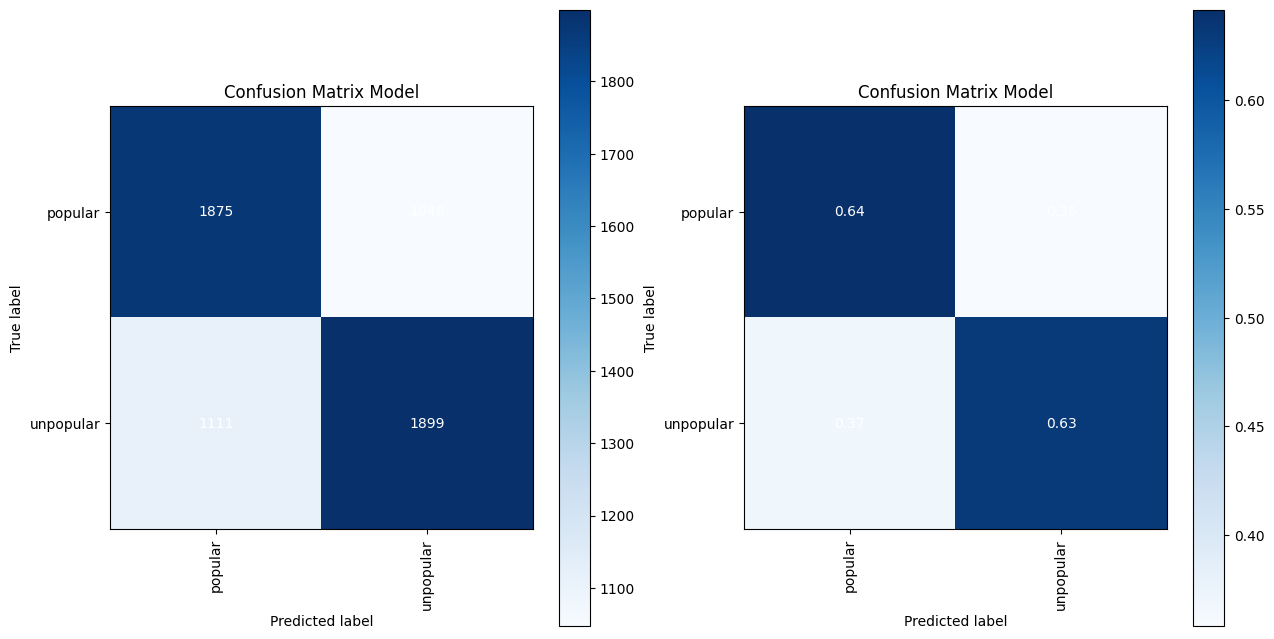

acc: 0.6361031518624641
pre: 0.6443841194435018
recall: 0.6308970099667774
f1: 0.6375692462648984
AUCf1: 0.6361806295129816


In [7]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=160, objective='binary:logistic')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

## 绘制预测结果
# {'svm__C': 1, 'svm__gamma': 0.01}
cm = confusion_matrix(y_test, y_pred)
labels_name = ['popular','unpopular']
plot_confusion_matrix(cm, labels_name, "Confusion Matrix Model")
plt.show()
print("acc: " + str(accuracy_score(y_test, y_pred)))
print("pre: " + str(precision_score(y_test, y_pred)))
print("recall: " + str(recall_score(y_test, y_pred)))
print("f1: " + str(f1_score(y_test, y_pred)))
print("AUCf1: " + str(roc_auc_score(y_test, y_pred)))


In [17]:
X = data_set[A_idx]
X = X[:,0,:]
print(X)

[[ 7.31000000e+02  1.20000000e+01  2.19000000e+02 ... -1.87500000e-01
   0.00000000e+00  1.87500000e-01]
 [ 7.31000000e+02  9.00000000e+00  2.55000000e+02 ...  0.00000000e+00
   5.00000000e-01  0.00000000e+00]
 [ 7.31000000e+02  9.00000000e+00  2.11000000e+02 ...  0.00000000e+00
   5.00000000e-01  0.00000000e+00]
 ...
 [ 3.40000000e+02  1.40000000e+01  5.40000000e+02 ...  3.33333333e-01
   1.66666667e-01  3.33333333e-01]
 [ 3.40000000e+02  1.20000000e+01  8.02000000e+02 ...  0.00000000e+00
   5.00000000e-01  0.00000000e+00]
 [ 3.40000000e+02  1.10000000e+01  1.82000000e+02 ... -5.00000000e-01
   5.00000000e-01  5.00000000e-01]]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


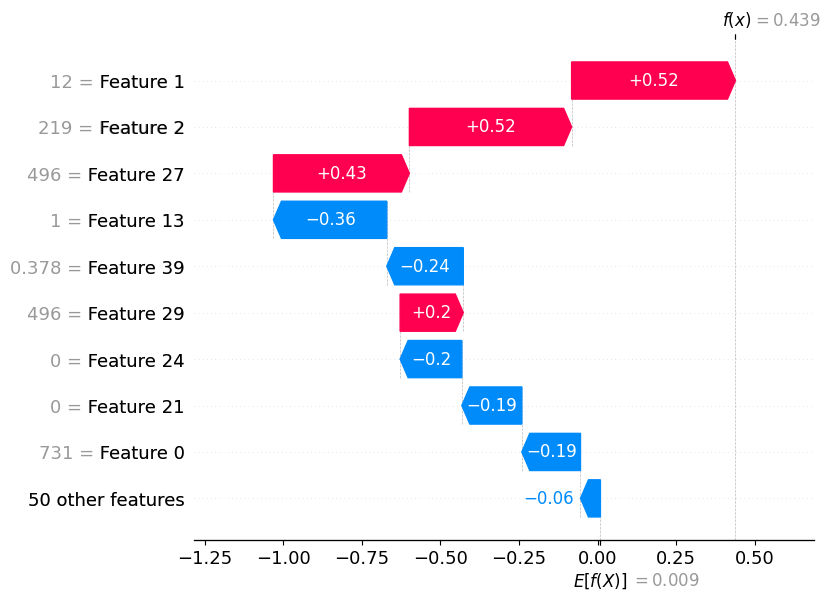

In [18]:
shap.initjs()
explainer = shap.Explainer(model)
X = data_set[A_idx]
X = X[:,0,:]
shap_values = explainer(X)
# waterfall图描述特征对第0个样本的正/负增益
shap.plots.waterfall(shap_values[0])

In [19]:
# force plot,visualize all the training set predictions
shap.plots.force(shap_values[0:100])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


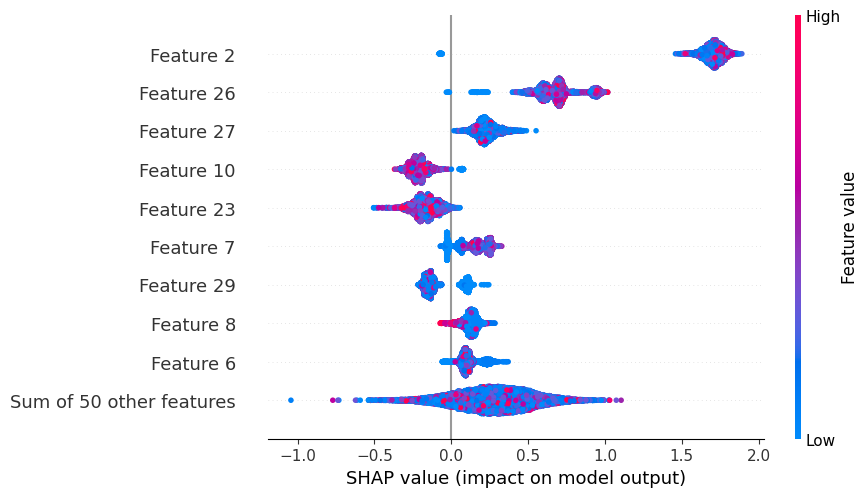

In [23]:
shap.initjs()
explainer = shap.Explainer(model)
X = data_set[A_idx]
X = X[:,0,:]
shap_values = explainer(X)
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [21]:
### 针对B_idx进行训练
x_train, x_test, y_train, y_test = train_test_split(data_set[B_idx], label_set[B_idx], test_size=0.3)

### 数据预处理
## 分别对训练集、验证集和测试集进行数据标准化
scaler = StandardScaler()     
x_train = scaler.fit_transform(x_train.squeeze())     # 完整训练集
x_test = scaler.fit_transform(x_test.squeeze())       # 测试集

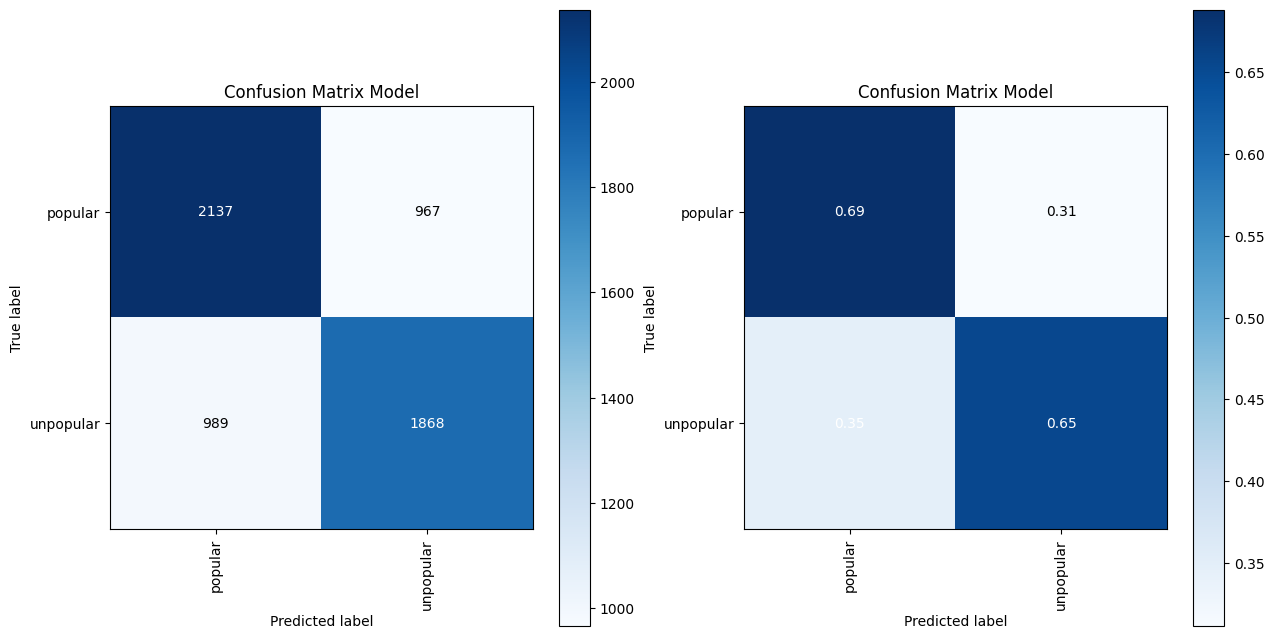

acc: 0.6718671363865123
pre: 0.6589065255731923
recall: 0.6538326916345817
f1: 0.6563598032326071
AUCf1: 0.6711495932399711


In [22]:
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=160, objective='binary:logistic')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

## 绘制预测结果
# {'svm__C': 1, 'svm__gamma': 0.01}
cm = confusion_matrix(y_test, y_pred)
labels_name = ['popular','unpopular']
plot_confusion_matrix(cm, labels_name, "Confusion Matrix Model")
plt.show()
print("acc: " + str(accuracy_score(y_test, y_pred)))
print("pre: " + str(precision_score(y_test, y_pred)))
print("recall: " + str(recall_score(y_test, y_pred)))
print("f1: " + str(f1_score(y_test, y_pred)))
print("AUCf1: " + str(roc_auc_score(y_test, y_pred)))